<a href="https://colab.research.google.com/github/AmrtanshuBharadwaj/DualVirusEpidemic/blob/main/DualVirusEpidemicFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt

from numpy.random import Generator, PCG64, SeedSequence
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x7ec6512bf690>


Main function of the simulation

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

def calculate_node_propensities(G, beta, sigma, mu, transition_beta, transition_sigma):
    for node in G.nodes:
        state = G.nodes[node]['state']
        if state == 0:  # Susceptible
            infected_neighbors_v1 = sum(G.nodes[neighbor]['state'] == 2 for neighbor in G.neighbors(node))
            infected_neighbors_v2 = sum(G.nodes[neighbor]['state'] == 4 for neighbor in G.neighbors(node))
            G.nodes[node]['lambda_v1'] = beta * infected_neighbors_v1
            G.nodes[node]['lambda_v2'] = beta * infected_neighbors_v2
            G.nodes[node]['lambda'] = G.nodes[node]['lambda_v1'] + G.nodes[node]['lambda_v2']
        elif state == 1:  # Exposed v1
            G.nodes[node]['lambda'] = sigma + transition_beta
        elif state == 3:  # Exposed v2
            G.nodes[node]['lambda'] = sigma
        elif state == 2:  # Infectious v1
            G.nodes[node]['lambda'] = mu + transition_sigma
        elif state == 4:  # Infectious v2
            G.nodes[node]['lambda'] = mu
        else:
            G.nodes[node]['lambda'] = 0

        G.nodes[node]['tau'] = -np.log(random.random()) / G.nodes[node]['lambda'] if G.nodes[node]['lambda'] > 0 else float('inf')

def draw_next_event_first_reaction(G):
    waiting_times = [(node, G.nodes[node]['tau']) for node in G.nodes if 'tau' in G.nodes[node]]
    if not waiting_times:
        return None, None
    min_node, tau = min(waiting_times, key=lambda x: x[1])
    return min_node, tau

def update_states(G, X, tau, i_selected, beta, sigma, mu, transition_beta, transition_sigma):
    S, E_v1, I_v1, R_v1, E_v2, I_v2, R_v2 = X
    state = G.nodes[i_selected]['state']

    for node in G.nodes:
        if 'tau' in G.nodes[node]:
            G.nodes[node]['tau'] -= tau

    if state == 0:
        if G.nodes[i_selected]['lambda_v1'] > G.nodes[i_selected]['lambda_v2']:
            G.nodes[i_selected]['state'] = 1
            E_v1 += 1
        else:
            G.nodes[i_selected]['state'] = 3
            E_v2 += 1
        S -= 1
    elif state == 1:
        random_choice = random.random() * (sigma + transition_beta)
        if random_choice < sigma:
            G.nodes[i_selected]['state'] = 2
            E_v1 -= 1
            I_v1 += 1
        else:
            G.nodes[i_selected]['state'] = 3
            E_v1 -= 1
            E_v2 += 1
    elif state == 3:
        G.nodes[i_selected]['state'] = 4
        E_v2 -= 1
        I_v2 += 1
    elif state == 2:
        random_choice = random.random() * (mu + transition_sigma)
        if random_choice < mu:
            G.nodes[i_selected]['state'] = 5
            I_v1 -= 1
            R_v1 += 1
        else:
            G.nodes[i_selected]['state'] = 4
            I_v1 -= 1
            I_v2 += 1
    elif state == 4:
        G.nodes[i_selected]['state'] = 6
        I_v2 -= 1
        R_v2 += 1

    calculate_node_propensities(G, beta, sigma, mu, transition_beta, transition_sigma)
    return [S, E_v1, I_v1, R_v1, E_v2, I_v2, R_v2]

def first_reaction_method_SEIR_graph(G, beta, mu, sigma, T, transition_beta, transition_sigma):
    N = len(G.nodes)
    S = N
    E_v1 = E_v2 = I_v1 = I_v2 = R_v1 = R_v2 = 0

    for node in G.nodes():
        G.nodes[node]['state'] = 0  # Initialize all nodes as susceptible
        G.nodes[node]['lambda'] = 0  # Initialize lambda

    initial_infected = random.choice(list(G.nodes))
    G.nodes[initial_infected]['state'] = 2  # Infectious with V1
    I_v1 = 1
    S -= 1

    calculate_node_propensities(G, beta, sigma, mu, transition_beta, transition_sigma)

    t = 0
    X_t = [[t, S, E_v1, I_v1, R_v1, E_v2, I_v2, R_v2]]

    while t < T:
        if not any('tau' in G.nodes[node] for node in G.nodes):
            break

        i_selected, tau = draw_next_event_first_reaction(G)
        if i_selected is None:
            break

        t += tau
        state_counts = update_states(G, [S, E_v1, I_v1, R_v1, E_v2, I_v2, R_v2], tau, i_selected, beta, sigma, mu, transition_beta, transition_sigma)
        S, E_v1, I_v1, R_v1, E_v2, I_v2, R_v2 = state_counts

        X_t.append([t, S, E_v1, I_v1, R_v1, E_v2, I_v2, R_v2])

    return np.array(X_t).transpose()


# Update the initialization and simulation loop with the new function arguments
# Ensure you pass `transition_beta` and `transition_sigma` where required


Vary the parameters and run the simulation

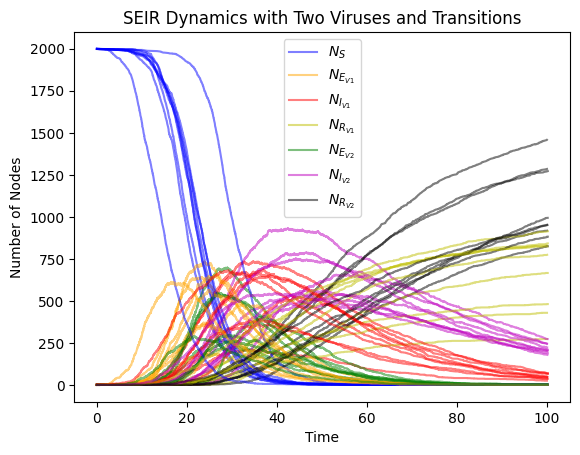

In [ ]:
# Simulation loop setup
beta = 0.3
mu = 0.03
sigma = 0.1
transition_beta = 0.02  # Transition rate from E1 to E2
transition_sigma = 0.015  # Transition rate from I1 to I2
k = 6
N = 2000
T = 100
Q = 10

G0 = nx.barabasi_albert_graph(n=N, m=int(k/2)) #Thsi is ScaleFree #For ER network use nx.gnm_random_graph(n=N, m=k*N/2)

X_array = []
for q in range(Q):
    G = G0.copy()
    nx.set_node_attributes(G, 0, 'state')
    X_t = first_reaction_method_SEIR_graph(G, beta, mu, sigma, T, transition_beta, transition_sigma)
    X_array.append(X_t)

# Plotting results
colors = ['b', 'orange', 'r', 'y', 'g', 'm', 'k']
legends = [r'$N_S$', r'$N_{E_{V1}}$', r'$N_{I_{V1}}$', r'$N_{R_{V1}}$', r'$N_{E_{V2}}$', r'$N_{I_{V2}}$', r'$N_{R_{V2}}$']

fig = plt.figure()
ax = plt.subplot()

for X_t in X_array:
    for X_, c_ in zip(X_t[1:], colors):
        ax.plot(X_t[0], X_, c=c_, alpha=0.5)

ax.legend(legends)
plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('SEIR Dynamics with Two Viruses and Transitions')
plt.show()


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


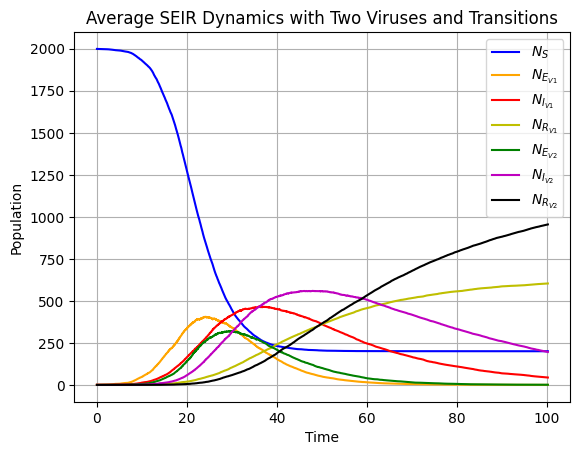

In [ ]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np

common_time = []

# Assuming you have X_array defined earlier

for X in X_array:
    common_time.extend(X[0])
common_time = list(set(common_time))
common_time.sort()

interpolated_values = [[] for _ in range(7)]

for X in X_array:
    for i in range(7):
        f = interpolate.interp1d(X[0], X[i + 1], kind='linear', fill_value="extrapolate")
        interpolated_values[i].append(f(common_time))

average_values = [np.mean(interpolated_values[i], axis=0) for i in range(7)]

colors = ['b', 'orange', 'r', 'y', 'g', 'm', 'k']
legends = [r'$N_S$', r'$N_{E_{V1}}$', r'$N_{I_{V1}}$', r'$N_{R_{V1}}$', r'$N_{E_{V2}}$', r'$N_{I_{V2}}$', r'$N_{R_{V2}}$']

fig = plt.figure()
ax = plt.subplot()

for X_, c_, legend in zip(average_values, colors, legends):
    ax.plot(common_time, X_, c=c_, label=legend)

ax.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average SEIR Dynamics with Two Viruses and Transitions')

plt.grid()
plt.show()


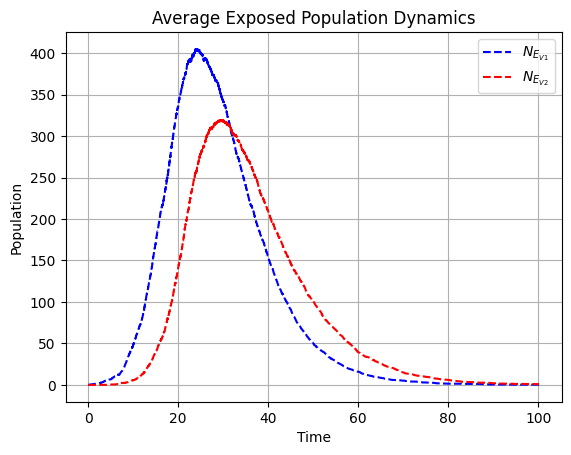

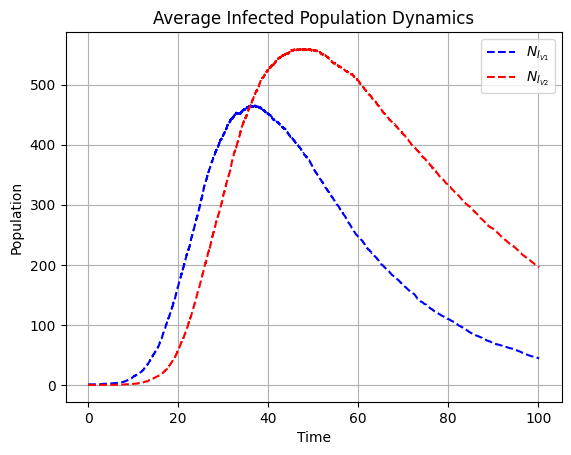

In [ ]:
# Plotting E1 and E2
fig, ax = plt.subplots()
ax.plot(common_time, average_values[1], label=r'$N_{E_{V1}}$', linestyle='--', color='b')
ax.plot(common_time, average_values[4], label=r'$N_{E_{V2}}$', linestyle='--', color='r')

ax.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average Exposed Population Dynamics')
plt.grid()
plt.show()

# Plotting I1 and I2
fig, ax = plt.subplots()
ax.plot(common_time, average_values[2], label=r'$N_{I_{V1}}$', linestyle='--', color='b')
ax.plot(common_time, average_values[5], label=r'$N_{I_{V2}}$', linestyle='--', color='r')

ax.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average Infected Population Dynamics')
plt.grid()
plt.show()


<ipython-input-22-6fddc78efdce>:4: RuntimeWarning: Mean of empty slice
  valid_average_values = [np.nanmean(arr, axis=0) for arr in interpolated_values]


Peak time for exposure (E1): inf, Peak exposure value: nan
Peak time for exposure (E2): inf, Peak exposure value: nan
Peak time for infection (I1): 36.12, Peak infection value: 465
Peak time for infection (I2): 47.97, Peak infection value: 560


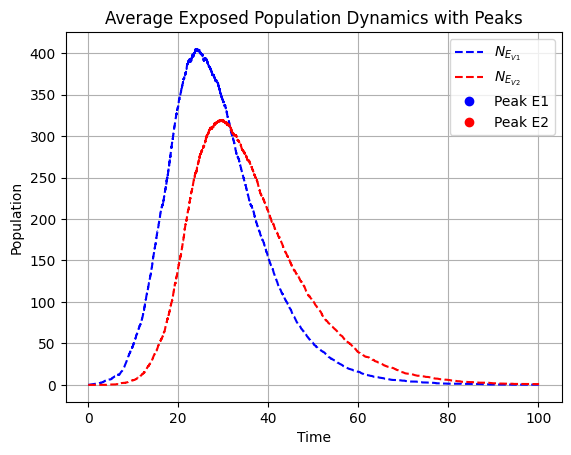

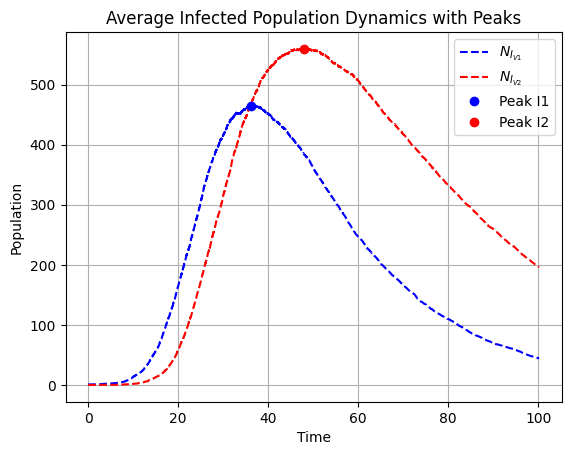

In [ ]:
import numpy as np

# Calculate the average values excluding nan values
valid_average_values = [np.nanmean(arr, axis=0) for arr in interpolated_values]

# Find the peak times and peak values for exposures (E1 and E2)
peak_time_E1 = common_time[np.argmax(valid_average_values[1])]
peak_value_E1 = np.max(valid_average_values[1])

peak_time_E2 = common_time[np.argmax(valid_average_values[4])]
peak_value_E2 = np.max(valid_average_values[4])

# Find the peak times and peak values for infections (I1 and I2)
peak_time_I1 = common_time[np.argmax(valid_average_values[2])]
peak_value_I1 = np.max(valid_average_values[2])

peak_time_I2 = common_time[np.argmax(valid_average_values[5])]
peak_value_I2 = np.max(valid_average_values[5])

# Print the results
print(f"Peak time for exposure (E1): {peak_time_E1:.2f}, Peak exposure value: {peak_value_E1:.0f}")
print(f"Peak time for exposure (E2): {peak_time_E2:.2f}, Peak exposure value: {peak_value_E2:.0f}")
print(f"Peak time for infection (I1): {peak_time_I1:.2f}, Peak infection value: {peak_value_I1:.0f}")
print(f"Peak time for infection (I2): {peak_time_I2:.2f}, Peak infection value: {peak_value_I2:.0f}")

# Plotting peak times
fig, ax = plt.subplots()
ax.plot(common_time, valid_average_values[1], label=r'$N_{E_{V1}}$', linestyle='--', color='b')
ax.plot(common_time, valid_average_values[4], label=r'$N_{E_{V2}}$', linestyle='--', color='r')
ax.plot(peak_time_E1, peak_value_E1, 'bo', label='Peak E1')
ax.plot(peak_time_E2, peak_value_E2, 'ro', label='Peak E2')
ax.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average Exposed Population Dynamics with Peaks')
plt.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(common_time, valid_average_values[2], label=r'$N_{I_{V1}}$', linestyle='--', color='b')
ax.plot(common_time, valid_average_values[5], label=r'$N_{I_{V2}}$', linestyle='--', color='r')
ax.plot(peak_time_I1, peak_value_I1, 'bo', label='Peak I1')
ax.plot(peak_time_I2, peak_value_I2, 'ro', label='Peak I2')
ax.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average Infected Population Dynamics with Peaks')
plt.grid()
plt.show()



Peak time for exposure (E1): 24.23, Peak exposure value: 405
Peak time for exposure (E2): 29.30, Peak exposure value: 320


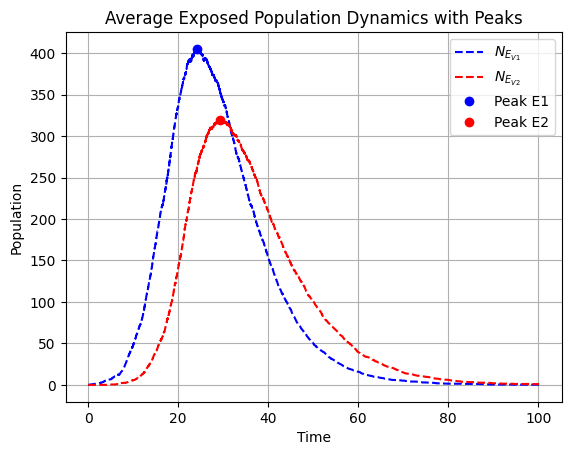

In [ ]:
# Find the peak times and peak values for exposures (E1 and E2)
peak_value_E1 = -np.inf
peak_time_E1 = None
for i, val in enumerate(average_values[1]):
    if np.isfinite(val) and val > peak_value_E1:
        peak_value_E1 = val
        peak_time_E1 = common_time[i]

peak_value_E2 = -np.inf
peak_time_E2 = None
for i, val in enumerate(average_values[4]):
    if np.isfinite(val) and val > peak_value_E2:
        peak_value_E2 = val
        peak_time_E2 = common_time[i]

# Print the results
print(f"Peak time for exposure (E1): {peak_time_E1:.2f}, Peak exposure value: {peak_value_E1:.0f}")
print(f"Peak time for exposure (E2): {peak_time_E2:.2f}, Peak exposure value: {peak_value_E2:.0f}")

# Plotting peak times
fig, ax = plt.subplots()
ax.plot(common_time, average_values[1], label=r'$N_{E_{V1}}$', linestyle='--', color='b')
ax.plot(common_time, average_values[4], label=r'$N_{E_{V2}}$', linestyle='--', color='r')
ax.plot(peak_time_E1, peak_value_E1, 'bo', label='Peak E1')
ax.plot(peak_time_E2, peak_value_E2, 'ro', label='Peak E2')
ax.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average Exposed Population Dynamics with Peaks')
plt.grid()
plt.show()
